<style>
    /* Main container style */
    .note-box {
        background-color: #1e1e2e;       /* Dark Blue-Grey Background */
        color: #cdd6f4;                  /* Soft White Text */
        border-left: 6px solid #89b4fa;  /* Blue Accent Border */
        border-radius: 8px;
        padding: 20px;
        margin: 20px 0;
        font-family: system-ui, -apple-system, sans-serif;
        line-height: 1.6;
        box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2);
        box-sizing: border-box;
        max-width: 100%;
        overflow-wrap: break-word;
    }
    
    /* Header style */
    .note-box h2 {
        color: #89b4fa;                  /* Blue Header */
        margin-top: 0;
        margin-bottom: 15px;
        font-size: 1.6rem;
        font-weight: 600;
        border-bottom: 1px solid #45475a;
        padding-bottom: 10px;
    }

    /* Important keywords */
    .note-box strong {
        color: #f9e2af;                  /* Soft Gold/Yellow */
        font-weight: 600;
    }

    /* Inline code snippets */
    .note-box .code-inline {
        background-color: #313244;
        color: #f38ba8;                  /* Soft Red/Pink */
        padding: 2px 6px;
        border-radius: 4px;
        font-family: 'Menlo', 'Consolas', monospace;
        font-size: 0.9em;
        border: 1px solid #45475a;
        white-space: pre-wrap;
    }

    /* Lists */
    .note-box ul {
        padding-left: 20px;
        margin: 10px 0;
    }
    .note-box li {
        margin-bottom: 8px;
    }
</style>
<div class="note-box">
    <h2>Chapter 4.5: Sequence to Sequence (Seq2Seq) & Attention</h2>
    <p>
        <strong>Objective</strong>: Build a model that can translate English to French.
    </p>
    <p><strong>The Challenge</strong>: In previous chapters, input and output lengths were fixed or 1-to-1. In translation, the input ("I love AI") has length 3, but the output ("J'adore l'intelligence artificielle") might have length 4. We need a flexible architecture that maps Sequence $N$ $\rightarrow$ Sequence $M$.</p>
    <p><strong>The Solution</strong>: The Encoder-Decoder Architecture.</p>
    <ul>
        <li><strong>Encoder</strong>: Reads the input sentence and compresses it into a single "Context Vector" (the final hidden state).</li>
        <li><strong>Decoder</strong>: Takes that context vector and unfolds it into a new sentence in the target language.</li>
        <li><strong>Attention</strong>: A mechanism that allows the Decoder to "look back" at specific source words during generation, fixing the bottleneck of a single context vector.</li>
    </ul>
</div>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random

# Force deterministic behavior for reproducibility
random.seed(42)
torch.manual_seed(42)

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


<style>
    /* Main container style */
    .note-box {
        background-color: #1e1e2e;       /* Dark Blue-Grey Background */
        color: #cdd6f4;                  /* Soft White Text */
        border-left: 6px solid #89b4fa;  /* Blue Accent Border */
        border-radius: 8px;
        padding: 20px;
        margin: 20px 0;
        font-family: system-ui, -apple-system, sans-serif;
        line-height: 1.6;
        box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2);
        box-sizing: border-box;
        max-width: 100%;
        overflow-wrap: break-word;
    }
    
    /* Header style */
    .note-box h2 {
        color: #89b4fa;                  /* Blue Header */
        margin-top: 0;
        margin-bottom: 15px;
        font-size: 1.6rem;
        font-weight: 600;
        border-bottom: 1px solid #45475a;
        padding-bottom: 10px;
    }

    /* Important keywords */
    .note-box strong {
        color: #f9e2af;                  /* Soft Gold/Yellow */
        font-weight: 600;
    }

    /* Inline code snippets */
    .note-box .code-inline {
        background-color: #313244;
        color: #f38ba8;                  /* Soft Red/Pink */
        padding: 2px 6px;
        border-radius: 4px;
        font-family: 'Menlo', 'Consolas', monospace;
        font-size: 0.9em;
        border: 1px solid #45475a;
        white-space: pre-wrap;
    }

    /* Lists */
    .note-box ul {
        padding-left: 20px;
        margin: 10px 0;
    }
    .note-box li {
        margin-bottom: 8px;
    }
</style>
<div class="note-box">
    <h2>Step 1: The Data</h2>
    <p>We will use a tiny synthetic dataset of English-French pairs. In a real scenario, you would use thousands of sentence pairs.</p>
    <p><strong>Special Tokens</strong>:</p>
    <ul>
        <li><span class="code-inline">&lt;SOS&gt;</span> (Start Of Sentence): Tells the decoder to start generating.</li>
        <li><span class="code-inline">&lt;EOS&gt;</span> (End Of Sentence): Tells the decoder to stop.</li>
    </ul>
</div>

In [2]:
# Raw Data: (English, French)
raw_data = [
    ("hello", "bonjour"),
    ("how are you", "comment ca va"),
    ("good morning", "bonjour"),
    ("i love ai", "j'aime l'ia"),
    ("deep learning is cool", "l'apprentissage profond est cool"),
    ("goodbye", "au revoir"),
    ("see you later", "a plus tard"),
    ("cat", "chat"),
    ("dog", "chien"),
    ("red", "rouge"),
    ("blue", "bleu")
]

# Vocabulary helpers
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"<SOS>": 0, "<EOS>": 1}
        self.index2word = {0: "<SOS>", 1: "<EOS>"}
        self.n_words = 2

    def addSentence(self, sentence):
        for word in sentence.split():
            if word not in self.word2index:
                self.word2index[word] = self.n_words
                self.index2word[self.n_words] = word
                self.n_words += 1

    def tensorFromSentence(self, sentence):
        indexes = [self.word2index[word] for word in sentence.split()]
        indexes.append(self.word2index["<EOS>"])
        return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

# Build Vocabs
input_lang = Lang("eng")
output_lang = Lang("fra")

for pair in raw_data:
    input_lang.addSentence(pair[0])
    output_lang.addSentence(pair[1])

print(f"English Vocab: {input_lang.n_words} words")
print(f"French Vocab: {output_lang.n_words} words")
print(f"Sample: 'hello' -> {input_lang.tensorFromSentence('hello').t()}")

English Vocab: 22 words
French Vocab: 21 words
Sample: 'hello' -> tensor([[2, 1]], device='mps:0')


<style>
    /* Main container style */
    .note-box {
        background-color: #1e1e2e;       /* Dark Blue-Grey Background */
        color: #cdd6f4;                  /* Soft White Text */
        border-left: 6px solid #89b4fa;  /* Blue Accent Border */
        border-radius: 8px;
        padding: 20px;
        margin: 20px 0;
        font-family: system-ui, -apple-system, sans-serif;
        line-height: 1.6;
        box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2);
        box-sizing: border-box;
        max-width: 100%;
        overflow-wrap: break-word;
    }
    
    /* Header style */
    .note-box h2 {
        color: #89b4fa;                  /* Blue Header */
        margin-top: 0;
        margin-bottom: 15px;
        font-size: 1.6rem;
        font-weight: 600;
        border-bottom: 1px solid #45475a;
        padding-bottom: 10px;
    }

    /* Important keywords */
    .note-box strong {
        color: #f9e2af;                  /* Soft Gold/Yellow */
        font-weight: 600;
    }

    /* Inline code snippets */
    .note-box .code-inline {
        background-color: #313244;
        color: #f38ba8;                  /* Soft Red/Pink */
        padding: 2px 6px;
        border-radius: 4px;
        font-family: 'Menlo', 'Consolas', monospace;
        font-size: 0.9em;
        border: 1px solid #45475a;
        white-space: pre-wrap;
    }

    /* Lists */
    .note-box ul {
        padding-left: 20px;
        margin: 10px 0;
    }
    .note-box li {
        margin-bottom: 8px;
    }
</style>
<div class="note-box">
    <h2>Step 2: The Encoder</h2>
    <p>The Encoder is a simple RNN (GRU in this case). It takes words one by one and updates its hidden state.</p>
    <p>We strictly ignore the <em>outputs</em> of the encoder for now and only care about the <strong>Final Hidden State</strong>. This state represents the "meaning" of the entire input sentence.</p>
</div>

In [3]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        # input shape: [1, 1] (one word at a time)
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

<style>
    /* Main container style */
    .note-box {
        background-color: #1e1e2e;       /* Dark Blue-Grey Background */
        color: #cdd6f4;                  /* Soft White Text */
        border-left: 6px solid #89b4fa;  /* Blue Accent Border */
        border-radius: 8px;
        padding: 20px;
        margin: 20px 0;
        font-family: system-ui, -apple-system, sans-serif;
        line-height: 1.6;
        box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2);
        box-sizing: border-box;
        max-width: 100%;
        overflow-wrap: break-word;
    }
    
    /* Header style */
    .note-box h2 {
        color: #89b4fa;                  /* Blue Header */
        margin-top: 0;
        margin-bottom: 15px;
        font-size: 1.6rem;
        font-weight: 600;
        border-bottom: 1px solid #45475a;
        padding-bottom: 10px;
    }

    /* Important keywords */
    .note-box strong {
        color: #f9e2af;                  /* Soft Gold/Yellow */
        font-weight: 600;
    }

    /* Inline code snippets */
    .note-box .code-inline {
        background-color: #313244;
        color: #f38ba8;                  /* Soft Red/Pink */
        padding: 2px 6px;
        border-radius: 4px;
        font-family: 'Menlo', 'Consolas', monospace;
        font-size: 0.9em;
        border: 1px solid #45475a;
        white-space: pre-wrap;
    }

    /* Lists */
    .note-box ul {
        padding-left: 20px;
        margin: 10px 0;
    }
    .note-box li {
        margin-bottom: 8px;
    }
</style>
<div class="note-box">
    <h2>Deep Dive: The Attention Mechanism</h2>
    <p>
        In a standard Encoder-Decoder, the encoder must compress the entire sentence into a single vector. If the sentence is long, it forgets the beginning. <strong>Attention</strong> solves this by giving the Decoder access to <em>all</em> the Encoder's hidden states, not just the last one.
    </p>
    <p>At every step of decoding, we calculate a <strong>Context Vector</strong> based on which encoder words are most relevant right now.</p>

<h3>1. Calculate Attention Scores (Energies)</h3>
    <p>We compare the current Decoder Hidden State (<i>s<sub>t-1</sub></i>) with every Encoder Hidden State (<i>h<sub>j</sub></i>). There are many ways to do this; we will use a simple Linear layer method.</p>

$$ \text{score}(s_{t-1}, h_j) = W_a \cdot [s_{t-1}; h_j] $$

<h3>2. Calculate Attention Weights</h3>
    <p>We turn scores into probabilities using Softmax. This tells us "how much focus" to put on each input word.</p>

$$ \alpha_{t,j} = \frac{\exp(\text{score}(s_{t-1}, h_j))}{\sum_{k=1}^{N} \exp(\text{score}(s_{t-1}, h_k))} $$

<h3>3. The Context Vector</h3>
    <p>We compute the weighted sum of encoder hidden states. If <i>alpha<sub>t,j</sub></i> is high for the word "cat", the context vector will be very similar to the vector for "cat".</p>

$$ c_t = \sum_{j=1}^{N} \alpha_{t,j} h_j $$

<p>Finally, we combine this Context Vector <i>c<sub>t</sub></i> with the Decoder's current input to make a prediction.</p>
</div>

In [4]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, max_length=10):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        
        # 1. Attention Weights Layer
        # Takes (Previous_Hidden + Input_Embedding) -> Outputs scalar importance for each input word
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        
        # 2. Combine Layer
        # Takes (Input_Embedding + Context_Vector) -> GRU Input
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1) # [1, 1, hidden]

        # --- A. Calculate Attention Weights ---
        # Compare input with previous hidden state to decide focus
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        
        # --- B. Apply Attention (Weighted Sum) ---
        # bmm = Batch Matrix Multiplication
        # Weights [1, 1, max_len] * Encoder_Outputs [1, max_len, hidden]
        # Result: [1, 1, hidden] (The "Context Vector")
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        # --- C. Combine & Run GRU ---
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        
        output, hidden = self.gru(output, hidden)

        # --- D. Predict ---
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

<style>
    /* Main container style */
    .note-box {
        background-color: #1e1e2e;       /* Dark Blue-Grey Background */
        color: #cdd6f4;                  /* Soft White Text */
        border-left: 6px solid #89b4fa;  /* Blue Accent Border */
        border-radius: 8px;
        padding: 20px;
        margin: 20px 0;
        font-family: system-ui, -apple-system, sans-serif;
        line-height: 1.6;
        box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2);
        box-sizing: border-box;
        max-width: 100%;
        overflow-wrap: break-word;
    }
    
    /* Header style */
    .note-box h2 {
        color: #89b4fa;                  /* Blue Header */
        margin-top: 0;
        margin-bottom: 15px;
        font-size: 1.6rem;
        font-weight: 600;
        border-bottom: 1px solid #45475a;
        padding-bottom: 10px;
    }

    /* Important keywords */
    .note-box strong {
        color: #f9e2af;                  /* Soft Gold/Yellow */
        font-weight: 600;
    }

    /* Inline code snippets */
    .note-box .code-inline {
        background-color: #313244;
        color: #f38ba8;                  /* Soft Red/Pink */
        padding: 2px 6px;
        border-radius: 4px;
        font-family: 'Menlo', 'Consolas', monospace;
        font-size: 0.9em;
        border: 1px solid #45475a;
        white-space: pre-wrap;
    }

    /* Lists */
    .note-box ul {
        padding-left: 20px;
        margin: 10px 0;
    }
    .note-box li {
        margin-bottom: 8px;
    }
</style>
<div class="note-box">
    <h2>Step 3: Training & Teacher Forcing </h2>
    <p><strong>Teacher Forcing</strong> is a training technique that speeds up convergence.</p>
    <ul>
        <li><strong>Without TF</strong>: We feed the decoder's <em>own prediction</em> as input for the next step. If it guesses wrong early, the rest of the sentence becomes garbage, and learning is slow.</li>
        <li><strong>With TF</strong>: We feed the <em>actual correct ground truth</em> as input for the next step, regardless of what the model predicted.</li>
    </ul>
    <p>We use a <span class="code-inline">teacher_forcing_ratio</span> (e.g., 0.5) to randomly switch between these two modes.</p>
</div>

In [5]:
MAX_LENGTH = 10
HIDDEN_SIZE = 256

# Initialize Models
encoder = EncoderRNN(input_lang.n_words, HIDDEN_SIZE).to(device)
decoder = AttnDecoderRNN(HIDDEN_SIZE, output_lang.n_words, max_length=MAX_LENGTH).to(device)

encoder_optimizer = optim.SGD(encoder.parameters(), lr=0.01)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=0.01)
criterion = nn.NLLLoss()

def train_step(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    # 1. Run Encoder
    encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=device)
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    # 2. Run Decoder
    decoder_input = torch.tensor([[input_lang.word2index["<SOS>"]]], device=device) # Start Token
    decoder_hidden = encoder_hidden # Use encoder's final hidden state to start decoder
    
    loss = 0
    # Teacher Forcing?
    use_teacher_forcing = True if random.random() < 0.5 else False

    if use_teacher_forcing:
        # Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di] # Teacher forcing
    else:
        # Feed the prediction as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.detach() # Detach from history as input
            if decoder_input.item() == output_lang.word2index["<EOS>"]:
                break

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

# Run Training
print("--- Training Started ---")
for epoch in range(1, 201):
    # Pick random pair
    training_pair = raw_data[random.randint(0, len(raw_data) - 1)]
    input_tensor = input_lang.tensorFromSentence(training_pair[0])
    target_tensor = output_lang.tensorFromSentence(training_pair[1])

    loss = train_step(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch} | Loss: {loss:.4f}")

--- Training Started ---
Epoch 50 | Loss: 1.4158
Epoch 100 | Loss: 2.2825
Epoch 150 | Loss: 1.8364
Epoch 200 | Loss: 2.3355


In [6]:
def evaluate(sentence):
    with torch.no_grad():
        input_tensor = input_lang.tensorFromSentence(sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        
        encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=device)
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[input_lang.word2index["<SOS>"]]], device=device)
        decoder_hidden = encoder_hidden
        
        decoded_words = []
        
        for di in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            
            if topi.item() == output_lang.word2index["<EOS>"]:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])
            
            decoder_input = topi.squeeze().detach()

        return ' '.join(decoded_words)

print("\n--- Testing ---")
print("Input: 'hello' ->", evaluate("hello"))
print("Input: 'i love ai' ->", evaluate("i love ai"))
print("Input: 'red' ->", evaluate("red"))


--- Testing ---
Input: 'hello' -> bonjour <EOS>
Input: 'i love ai' -> j'aime <EOS>
Input: 'red' -> bonjour <EOS>


<style>
    /* Main container style */
    .note-box {
        background-color: #1e1e2e;       /* Dark Blue-Grey Background */
        color: #cdd6f4;                  /* Soft White Text */
        border-left: 6px solid #89b4fa;  /* Blue Accent Border */
        border-radius: 8px;
        padding: 20px;
        margin: 20px 0;
        font-family: system-ui, -apple-system, sans-serif;
        line-height: 1.6;
        box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2);
        box-sizing: border-box;
        max-width: 100%;
        overflow-wrap: break-word;
    }
    
    /* Header style */
    .note-box h2 {
        color: #89b4fa;                  /* Blue Header */
        margin-top: 0;
        margin-bottom: 15px;
        font-size: 1.6rem;
        font-weight: 600;
        border-bottom: 1px solid #45475a;
        padding-bottom: 10px;
    }

    /* Important keywords */
    .note-box strong {
        color: #f9e2af;                  /* Soft Gold/Yellow */
        font-weight: 600;
    }

    /* Inline code snippets */
    .note-box .code-inline {
        background-color: #313244;
        color: #f38ba8;                  /* Soft Red/Pink */
        padding: 2px 6px;
        border-radius: 4px;
        font-family: 'Menlo', 'Consolas', monospace;
        font-size: 0.9em;
        border: 1px solid #45475a;
        white-space: pre-wrap;
    }

    /* Lists */
    .note-box ul {
        padding-left: 20px;
        margin: 10px 0;
    }
    .note-box li {
        margin-bottom: 8px;
    }
</style>
<div class="note-box">
    <h2>Step 4: Visualizing Attention</h2>
    <p>
        One of the biggest benefits of Attention is <strong>Interpretability</strong>. We can visualize the attention weights matrix as a heatmap.
    </p>
    <ul>
        <li><strong>X-Axis</strong>: The input sentence (Source).</li>
        <li><strong>Y-Axis</strong>: The generated sentence (Target).</li>
        <li><strong>Color</strong>: How much the decoder "looked at" that specific input word while generating that specific output word.</li>
    </ul>
    <p>We need to modify our evaluation function slightly to return these attention weights for plotting.</p>
</div>

/var/folders/zd/lb23py7516dds983dt45vj3c0000gn/T/ipykernel_30676/2062656292.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split() + ['<EOS>'], rotation=90)
/var/folders/zd/lb23py7516dds983dt45vj3c0000gn/T/ipykernel_30676/2062656292.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


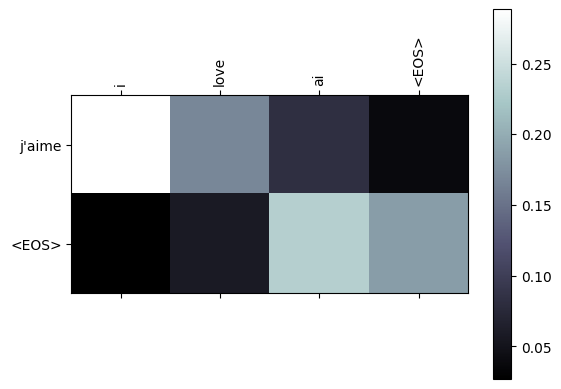

/var/folders/zd/lb23py7516dds983dt45vj3c0000gn/T/ipykernel_30676/2062656292.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split() + ['<EOS>'], rotation=90)
/var/folders/zd/lb23py7516dds983dt45vj3c0000gn/T/ipykernel_30676/2062656292.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


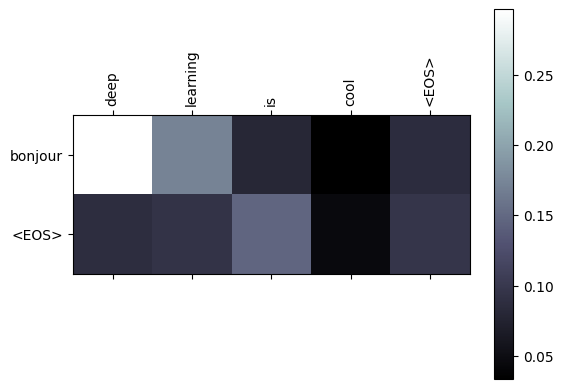

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # Move attention tensor to CPU for plotting
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split() + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def evaluateAndShowAttention(input_sentence):
    with torch.no_grad():
        input_tensor = input_lang.tensorFromSentence(input_sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=device)

        # 1. Run Encoder
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        # 2. Run Decoder
        decoder_input = torch.tensor([[input_lang.word2index["<SOS>"]]], device=device)
        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(MAX_LENGTH, MAX_LENGTH)

        for di in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            # Save attention weights (detach from graph)
            decoder_attentions[di] = attn_weights.data

            topv, topi = decoder_output.data.topk(1)
            if topi.item() == output_lang.word2index["<EOS>"]:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        # 3. Plot
        # We crop the matrix to the actual length of the sentences
        showAttention(input_sentence, decoded_words, decoder_attentions[:len(decoded_words), :input_length])

# Try it out!
evaluateAndShowAttention("i love ai")
evaluateAndShowAttention("deep learning is cool")

<style>
    /* Main container style */
    .note-box {
        background-color: #1e1e2e;       /* Dark Blue-Grey Background */
        color: #cdd6f4;                  /* Soft White Text */
        border-left: 6px solid #89b4fa;  /* Blue Accent Border */
        border-radius: 8px;
        padding: 20px;
        margin: 20px 0;
        font-family: system-ui, -apple-system, sans-serif;
        line-height: 1.6;
        box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2);
        box-sizing: border-box;
        max-width: 100%;
        overflow-wrap: break-word;
    }
    
    /* Header style */
    .note-box h2 {
        color: #89b4fa;                  /* Blue Header */
        margin-top: 0;
        margin-bottom: 15px;
        font-size: 1.6rem;
        font-weight: 600;
        border-bottom: 1px solid #45475a;
        padding-bottom: 10px;
    }

    /* Important keywords */
    .note-box strong {
        color: #f9e2af;                  /* Soft Gold/Yellow */
        font-weight: 600;
    }

    /* Inline code snippets */
    .note-box .code-inline {
        background-color: #313244;
        color: #f38ba8;                  /* Soft Red/Pink */
        padding: 2px 6px;
        border-radius: 4px;
        font-family: 'Menlo', 'Consolas', monospace;
        font-size: 0.9em;
        border: 1px solid #45475a;
        white-space: pre-wrap;
    }

    /* Lists */
    .note-box ul {
        padding-left: 20px;
        margin: 10px 0;
    }
    .note-box li {
        margin-bottom: 8px;
    }
</style>
<div class="note-box">
    <h2>Chapter Summary</h2>
    <p>Congratulations! You have built a complete <strong>Neural Machine Translation</strong> system.</p>
    <p><strong>What we learned:</strong></p>
    <ul>
        <li><strong>Seq2Seq</strong>: Handling variable length input and output sequences using an Encoder-Decoder architecture.</li>
        <li><strong>Teacher Forcing</strong>: Stabilizing training by using ground truth as input.</li>
        <li><strong>Attention</strong>: The breakthrough that allows models to handle long sequences by "focusing" on relevant parts of the input dynamically.</li>
    </ul>
    <p><strong>Next Steps:</strong> This architecture is the precursor to the <strong>Transformer</strong> (BERT, GPT), which replaces the RNN entirely with purely Attention mechanisms.</p>
</div>